In [113]:
import tensorflow as tf
tf.__version__
tf.config.experimental.enable_op_determinism()
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)

In [114]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt
import random

In [115]:
def plot_columns(df):
    colors = plt.cm.tab20(range(df.shape[1]))  

    for i, column in enumerate(df.columns):
        color = colors[i % 24]

        plt.figure()
        plt.plot(df.index, df[column], color=color)
        plt.xlabel('Tempo')
        plt.ylabel('Valor')
        plt.title(column)

    plt.show()

In [116]:
def plot_correlation_matrix(df):
    correlation_matrix = df.corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title("Correlation Matrix Heatmap")
    plt.show()

In [117]:
tf.keras.backend.clear_session()

In [118]:
subject = 'Santa Catarina - Consumo de Cimento (t)'
start_index = 0
split_index = 203
window_size = 36
train_split = split_index + 1 - 12

In [119]:
data = pd.read_csv('2003_mo_model_input_SC.csv')
pd.set_option('display.max_columns', None)
data

,Unnamed: 0,Santa Catarina - IDH,Santa Catarina - value,Santa Catarina - IDH Renda,Santa Catarina - Desemprego,Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Santa Catarina - IDH Longevidade,Santa Catarina - IDH Educacao,Santa Catarina - Consumo de Cimento (t),Santa Catarina - Produção de Cimento (t),Santa Catarina - PIB - Estadual,Santa Catarina - PIB - Construção Civil,Santa Catarina - PIB - Per Capita,Santa Catarina - PIB - Preços de Mercado,Santa Catarina- custo m2 (R$),Santa Catarina - Depósito Poupança (R$),Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%)
0,2003-1,0.797768,0.311113,0.807065,8.256606,1.631497,1018.765911,1169.178062,20.713332,16.132763,75.767229,2.323261,0.852921,0.752747,142.456,20.216800,1.320065e+08,6.638363e+06,19.725168,1.221860e+08,11270.272400,8.001967e+06,384683.093871,7.330309e+06,231.510748,2.097001e+06,1.036534,3.656420,0.969649,0.724032,-5331.049150,11.520143,126.459809,1.772069e+08,169.247665,1.611498
1,2003-2,0.797853,0.312787,0.806745,8.250731,1.632074,1018.754803,1169.161093,20.714658,16.135412,75.775096,2.323261,0.853282,0.752954,135.829,19.631031,1.321743e+08,6.642080e+06,19.732277,1.222513e+08,11377.902015,8.038182e+06,385266.203928,7.335910e+06,208.710157,2.000523e+06,0.993449,3.654697,0.950783,0.690297,-5318.079644,11.189862,126.581813,1.773884e+08,170.176810,1.450389
2,2003-3,0.797939,0.314207,0.806425,8.244856,1.632410,1018.748324,1169.151195,20.715432,16.136957,75.779686,2.323261,0.853644,0.753161,133.135,19.400920,1.323421e+08,6.645797e+06,19.739386,1.223166e+08,11480.211275,8.074397e+06,385305.059560,7.341511e+06,227.704841,1.963278e+06,0.973020,3.654266,0.938332,0.669681,-5436.417870,10.820792,126.703818,1.775699e+08,171.135713,1.870184
3,2003-4,0.798024,0.315571,0.806105,8.238982,1.632446,1018.747630,1169.150134,20.715515,16.137122,75.780177,2.323261,0.854005,0.753368,144.723,19.153741,1.325098e+08,6.649513e+06,19.746495,1.223818e+08,11578.298418,8.110613e+06,385752.052697,7.347112e+06,278.121073,1.954187e+06,0.940489,3.653595,0.926401,0.660494,-5707.015274,10.417840,126.825822,1.777514e+08,172.116904,1.355287
4,2003-5,0.798110,0.316880,0.805786,8.233107,1.808330,1017.949265,1212.045667,21.273488,16.656851,75.676757,2.319445,0.854366,0.753575,150.523,18.912155,1.326776e+08,6.653230e+06,19.753604,1.224471e+08,11673.320486,8.146828e+06,387164.022451,7.352713e+06,344.827633,1.975493e+06,0.917493,3.650266,0.951683,0.648337,-5599.317941,9.959690,126.976217,1.779329e+08,173.072271,1.585538
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
244,2023-5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,42497.575231,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
245,2023-6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,42463.822266,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
246,2023-7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,42375.031726,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
247,2023-8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,42265.885860,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


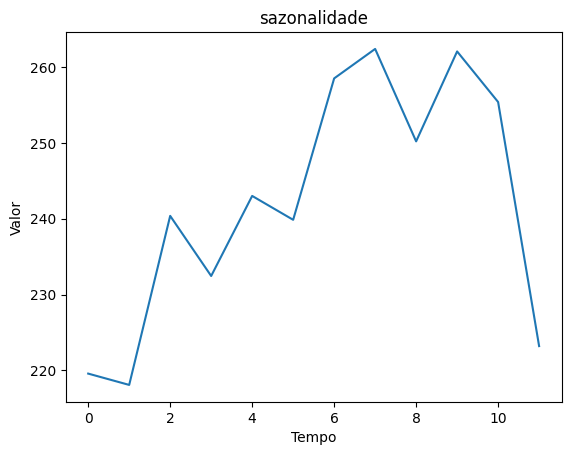

,sazonalidade
sazonalidade,
0,219.591071
1,218.098705
2,240.383349
3,232.458494
4,243.012756
5,239.863999
6,258.505989
7,262.392004
8,250.204324


In [120]:
def calculate_monthly_means(consume_of_cement, subject):
    df = pd.DataFrame({subject: consume_of_cement})
    df['sazonalidade'] = df.index % 12
    monthly_means = df.groupby('sazonalidade')[subject].mean()
    result_df = pd.DataFrame({'sazonalidade': monthly_means})

    return result_df

media_df = calculate_monthly_means(data[subject], subject)
plot_columns(media_df)
media_df

In [121]:
def fill_original_df_with_monthly_means(df_og, media_df):
    monthly_means = media_df['sazonalidade'].tolist()
    df_og['sazonalidade'] = [monthly_means[i % 12] for i in range(len(df_og))]
    return df_og

data = fill_original_df_with_monthly_means(data, media_df)
data = data[[col for col in data.columns if col != subject] + [subject]] #Seta consumo (target) para a coluna final
data

,Unnamed: 0,Santa Catarina - IDH,Santa Catarina - value,Santa Catarina - IDH Renda,Santa Catarina - Desemprego,Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Santa Catarina - IDH Longevidade,Santa Catarina - IDH Educacao,Santa Catarina - Produção de Cimento (t),Santa Catarina - PIB - Estadual,Santa Catarina - PIB - Construção Civil,Santa Catarina - PIB - Per Capita,Santa Catarina - PIB - Preços de Mercado,Santa Catarina- custo m2 (R$),Santa Catarina - Depósito Poupança (R$),Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%),sazonalidade,Santa Catarina - Consumo de Cimento (t)
0,2003-1,0.797768,0.311113,0.807065,8.256606,1.631497,1018.765911,1169.178062,20.713332,16.132763,75.767229,2.323261,0.852921,0.752747,20.216800,1.320065e+08,6.638363e+06,19.725168,1.221860e+08,11270.272400,8.001967e+06,384683.093871,7.330309e+06,231.510748,2.097001e+06,1.036534,3.656420,0.969649,0.724032,-5331.049150,11.520143,126.459809,1.772069e+08,169.247665,1.611498,219.591071,142.456
1,2003-2,0.797853,0.312787,0.806745,8.250731,1.632074,1018.754803,1169.161093,20.714658,16.135412,75.775096,2.323261,0.853282,0.752954,19.631031,1.321743e+08,6.642080e+06,19.732277,1.222513e+08,11377.902015,8.038182e+06,385266.203928,7.335910e+06,208.710157,2.000523e+06,0.993449,3.654697,0.950783,0.690297,-5318.079644,11.189862,126.581813,1.773884e+08,170.176810,1.450389,218.098705,135.829
2,2003-3,0.797939,0.314207,0.806425,8.244856,1.632410,1018.748324,1169.151195,20.715432,16.136957,75.779686,2.323261,0.853644,0.753161,19.400920,1.323421e+08,6.645797e+06,19.739386,1.223166e+08,11480.211275,8.074397e+06,385305.059560,7.341511e+06,227.704841,1.963278e+06,0.973020,3.654266,0.938332,0.669681,-5436.417870,10.820792,126.703818,1.775699e+08,171.135713,1.870184,240.383349,133.135
3,2003-4,0.798024,0.315571,0.806105,8.238982,1.632446,1018.747630,1169.150134,20.715515,16.137122,75.780177,2.323261,0.854005,0.753368,19.153741,1.325098e+08,6.649513e+06,19.746495,1.223818e+08,11578.298418,8.110613e+06,385752.052697,7.347112e+06,278.121073,1.954187e+06,0.940489,3.653595,0.926401,0.660494,-5707.015274,10.417840,126.825822,1.777514e+08,172.116904,1.355287,232.458494,144.723
4,2003-5,0.798110,0.316880,0.805786,8.233107,1.808330,1017.949265,1212.045667,21.273488,16.656851,75.676757,2.319445,0.854366,0.753575,18.912155,1.326776e+08,6.653230e+06,19.753604,1.224471e+08,11673.320486,8.146828e+06,387164.022451,7.352713e+06,344.827633,1.975493e+06,0.917493,3.650266,0.951683,0.648337,-5599.317941,9.959690,126.976217,1.779329e+08,173.072271,1.585538,243.012756,150.523
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
244,2023-5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,42497.575231,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,243.012756,NaN
245,2023-6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,42463.822266,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,239.863999,NaN
246,2023-7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,42375.031726,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,258.505989,NaN
247,2023-8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,42265.885860,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,262.392004,NaN


In [122]:
# Shift para prever futuro e não presente
target_data = data[subject].shift(-24)
target_data

0      134.837
1      136.495
2      154.807
3      146.582
4      149.537
        ...   
244        NaN
245        NaN
246        NaN
247        NaN
248        NaN
Name: Santa Catarina - Consumo de Cimento (t), Length: 249, dtype: float64

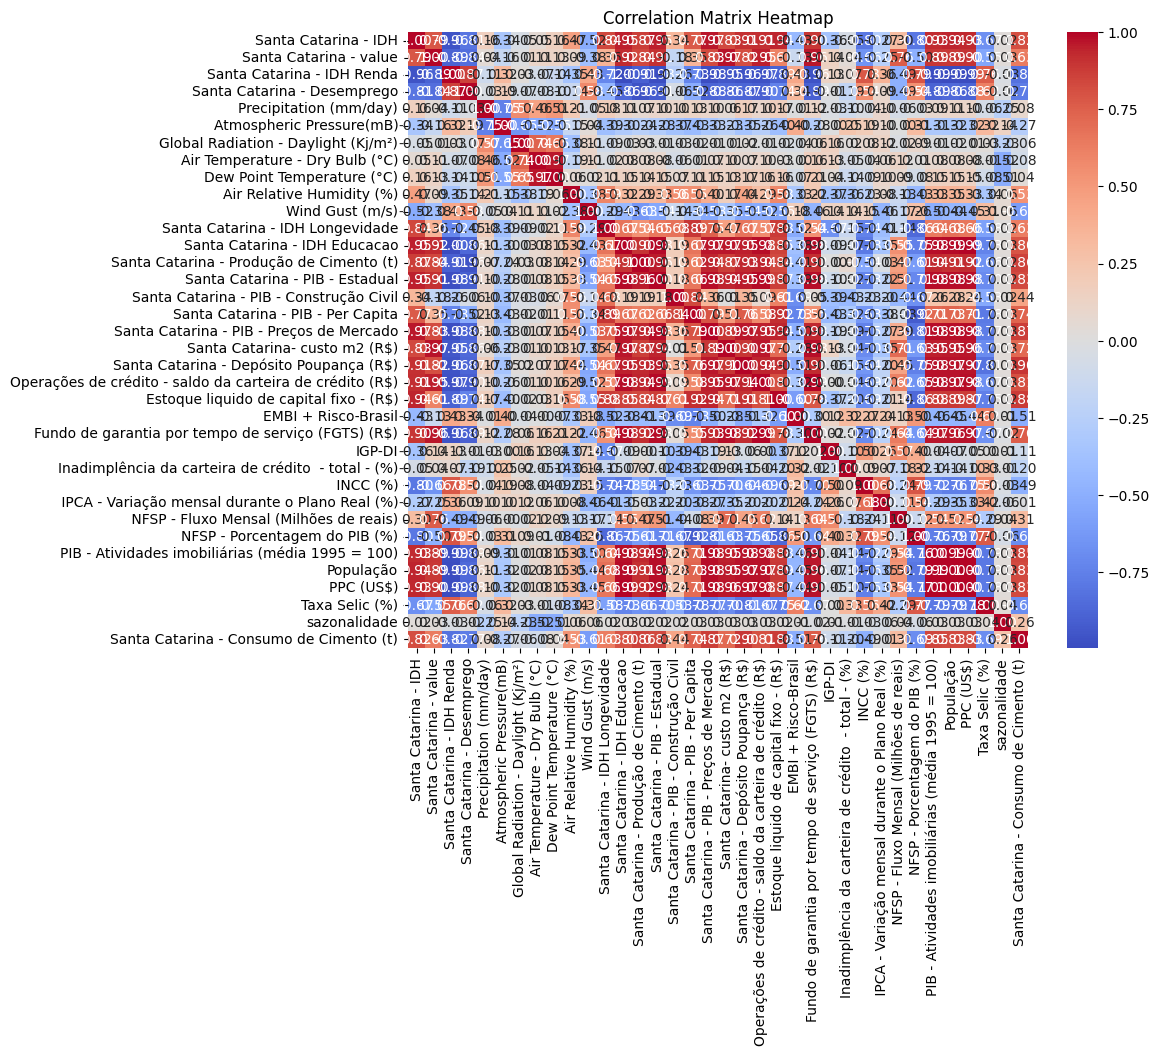

In [123]:
plot_data = data.iloc[:split_index + 1,1:]
plot_correlation_matrix(plot_data)

In [124]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

safe_data = data.iloc[:split_index + 1,1:-1]

def calculate_vif(dataframe):
    vif_data = pd.DataFrame()
    vif_data["Feature"] = dataframe.columns
    vif_data["VIF"] = [variance_inflation_factor(dataframe.values, i) for i in range(dataframe.shape[1])]
    return vif_data

def remove_high_vif_columns(dataframe, threshold=1000):
    i=0
    while True:
        vif_result = calculate_vif(dataframe)
        high_vif_column = vif_result.loc[vif_result["VIF"].idxmax()]["Feature"]
        
        if vif_result["VIF"].max() <= threshold:
            print(f"Num columns removed: {i}")
            return dataframe
        i += 1
        dataframe = dataframe.drop(high_vif_column, axis=1)

In [125]:
safe_data = data.iloc[:split_index + 1,1:-1]
vif_info = calculate_vif(safe_data)
vif_info

,Feature,VIF
0,Santa Catarina - IDH,3.006669e+09
1,Santa Catarina - value,4.264201e+05
2,Santa Catarina - IDH Renda,3.279591e+04
3,Santa Catarina - Desemprego,7.004134e+03
4,Precipitation (mm/day),2.082102e+02
5,Atmospheric Pressure(mB),1.929807e+06
6,Global Radiation - Daylight (Kj/m²),2.239194e+03
7,Air Temperature - Dry Bulb (°C),1.699705e+06
8,Dew Point Temperature (°C),1.136746e+06
9,Air Relative Humidity (%),1.155128e+06


In [126]:
# data = data.drop(['Global Radiation - Daylight (Kj/m²)',
#                  ' IPCA - Variação mensal durante o Plano Real (%)',
#                  'Global Radiation - Daylight (Kj/m²)', 
#                  'Air Temperature - Dry Bulb (°C)',
#                  'Dew Point Temperature (°C)',
#                  'Santa Catarina - Produção de Cimento (t)',
#                  'Santa Catarina- custo m2 (R$)'], axis=1)
data = remove_high_vif_columns(safe_data, 1000000)
data

Num columns removed: 9


,Santa Catarina - value,Santa Catarina - Desemprego,Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Santa Catarina - Produção de Cimento (t),Santa Catarina - PIB - Estadual,Santa Catarina- custo m2 (R$),Santa Catarina - Depósito Poupança (R$),Operações de crédito - saldo da carteira de crédito (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),PPC (US$),Taxa Selic (%),sazonalidade
0,0.311113,8.256606,1.631497,1018.765911,1169.178062,20.713332,16.132763,75.767229,2.323261,20.216800,1.320065e+08,11270.272400,8.001967e+06,3.846831e+05,231.510748,2.097001e+06,1.036534,3.656420,0.969649,0.724032,-5331.049150,11.520143,126.459809,169.247665,1.611498,219.591071
1,0.312787,8.250731,1.632074,1018.754803,1169.161093,20.714658,16.135412,75.775096,2.323261,19.631031,1.321743e+08,11377.902015,8.038182e+06,3.852662e+05,208.710157,2.000523e+06,0.993449,3.654697,0.950783,0.690297,-5318.079644,11.189862,126.581813,170.176810,1.450389,218.098705
2,0.314207,8.244856,1.632410,1018.748324,1169.151195,20.715432,16.136957,75.779686,2.323261,19.400920,1.323421e+08,11480.211275,8.074397e+06,3.853051e+05,227.704841,1.963278e+06,0.973020,3.654266,0.938332,0.669681,-5436.417870,10.820792,126.703818,171.135713,1.870184,240.383349
3,0.315571,8.238982,1.632446,1018.747630,1169.150134,20.715515,16.137122,75.780177,2.323261,19.153741,1.325098e+08,11578.298418,8.110613e+06,3.857521e+05,278.121073,1.954187e+06,0.940489,3.653595,0.926401,0.660494,-5707.015274,10.417840,126.825822,172.116904,1.355287,232.458494
4,0.316880,8.233107,1.808330,1017.949265,1212.045667,21.273488,16.656851,75.676757,2.319445,18.912155,1.326776e+08,11673.320486,8.146828e+06,3.871640e+05,344.827633,1.975493e+06,0.917493,3.650266,0.951683,0.648337,-5599.317941,9.959690,126.976217,173.072271,1.585538,243.012756
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199,0.557085,5.291382,1.049412,1017.850850,1090.848638,19.933315,15.417353,76.222341,2.219651,134.617516,1.572686e+08,32151.532751,2.058206e+07,3.339533e+06,256.861070,1.038665e+07,1.139835,3.035443,0.628071,0.411247,6518.883661,1.836884,207.092470,437.906135,0.516394,262.392004
200,0.559917,5.284043,1.261440,1016.502447,1183.958010,20.830592,16.102645,75.405782,2.286321,135.660357,1.571110e+08,32419.041432,2.075174e+07,3.365687e+06,257.536049,1.036684e+07,1.152658,3.032326,0.635009,0.433581,6534.198970,1.814025,207.285636,438.554287,0.509923,250.204324
201,0.562581,5.276704,1.417096,1015.217588,1276.826135,21.957559,17.031881,74.674423,2.318504,137.130984,1.569534e+08,32693.675515,2.092143e+07,3.396904e+06,259.995111,1.094126e+07,1.188899,3.007554,0.648424,0.461431,6135.626515,1.810325,207.478801,439.156241,0.467083,262.060571
202,0.565684,5.269366,1.506609,1014.563526,1334.861352,22.757039,17.547850,73.496215,2.312725,137.996561,1.567958e+08,32977.901119,2.109111e+07,3.425371e+06,262.843441,1.165215e+07,1.180399,2.995976,0.663946,0.480964,6503.475785,1.810689,207.781676,439.704663,0.441494,255.391914


In [127]:
input_data = data.iloc[:split_index + 1,1:-1]
mean = np.mean(input_data, axis=0)
stddev =  np.std(input_data, axis=0)
input_data = ((input_data - mean) /stddev)
# scaler=MinMaxScaler()
# scaled_data = scaler.fit_transform(input_data)
# input_data = pd.DataFrame(scaled_data, columns=input_data.columns)
input_data

,Santa Catarina - Desemprego,Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Santa Catarina - Produção de Cimento (t),Santa Catarina - PIB - Estadual,Santa Catarina- custo m2 (R$),Santa Catarina - Depósito Poupança (R$),Operações de crédito - saldo da carteira de crédito (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),PPC (US$),Taxa Selic (%)
0,1.144333,-0.269144,0.789860,0.026484,-0.257412,-0.403369,-0.685717,0.815184,-1.213264,-1.741643,-1.414218,-1.692451,-1.405679,-0.581961,-1.384242,2.574314,1.320402,3.184489,2.782450,0.097384,4.506880,-1.894583,-1.851489,2.125141
1,1.139866,-0.267812,0.786062,0.026350,-0.256675,-0.401822,-0.682011,0.815184,-1.225164,-1.723589,-1.396892,-1.683828,-1.405133,-0.804750,-1.415865,2.334870,1.314693,3.029073,2.407943,0.100462,4.328460,-1.889555,-1.840236,1.610904
2,1.135399,-0.267035,0.783847,0.026272,-0.256244,-0.400920,-0.679849,0.815184,-1.229839,-1.705536,-1.380422,-1.675206,-1.405096,-0.619149,-1.428073,2.221334,1.313266,2.926505,2.179073,0.072380,4.129086,-1.884527,-1.828623,2.950828
3,1.130933,-0.266952,0.783609,0.026264,-0.256198,-0.400823,-0.679617,0.815184,-1.234860,-1.687482,-1.364632,-1.666583,-1.404678,-0.126522,-1.431053,2.040542,1.311046,2.828220,2.077086,0.008167,3.911409,-1.879499,-1.816740,1.307354
4,1.126466,0.139099,0.510652,0.363557,0.054108,-0.097213,-0.728335,0.807746,-1.239768,-1.669428,-1.349335,-1.657961,-1.403356,0.525280,-1.424070,1.912744,1.300019,3.036493,1.942128,0.033724,3.663912,-1.873302,-1.805169,2.042281
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199,-1.110193,-1.612969,0.477004,-0.589430,-0.691204,-0.821291,-0.471328,0.613229,1.110744,0.976987,1.947254,1.302756,1.360064,-0.334258,1.332879,3.148408,-0.736097,0.370628,-0.689886,2.909383,-0.724085,1.428371,1.402207,-1.370268
200,-1.115772,-1.123471,0.015990,0.142700,-0.192200,-0.420964,-0.855983,0.743181,1.131929,0.960026,1.990318,1.343156,1.384545,-0.327663,1.326386,3.219670,-0.746418,0.427775,-0.441954,2.913017,-0.736434,1.436331,1.410056,-1.390925
201,-1.121352,-0.764119,-0.423298,0.872934,0.434542,0.121869,-1.200502,0.805912,1.161804,0.943065,2.034529,1.383556,1.413764,-0.303635,1.514665,3.421082,-0.828457,0.538287,-0.132782,2.818435,-0.738433,1.444292,1.417346,-1.527663
202,-1.126932,-0.557464,-0.646919,1.329272,0.879158,0.423283,-1.755517,0.794648,1.179388,0.926105,2.080283,1.423956,1.440408,-0.275803,1.747673,3.373840,-0.866800,0.666156,0.084061,2.905726,-0.738236,1.456774,1.423988,-1.609340


In [128]:
# input para treinamento
train_input = input_data.iloc[start_index:train_split]
train_input

,Santa Catarina - Desemprego,Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Santa Catarina - Produção de Cimento (t),Santa Catarina - PIB - Estadual,Santa Catarina- custo m2 (R$),Santa Catarina - Depósito Poupança (R$),Operações de crédito - saldo da carteira de crédito (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),PPC (US$),Taxa Selic (%)
0,1.144333,-0.269144,0.789860,0.026484,-0.257412,-0.403369,-0.685717,0.815184,-1.213264,-1.741643,-1.414218,-1.692451,-1.405679,-0.581961,-1.384242,2.574314,1.320402,3.184489,2.782450,0.097384,4.506880,-1.894583,-1.851489,2.125141
1,1.139866,-0.267812,0.786062,0.026350,-0.256675,-0.401822,-0.682011,0.815184,-1.225164,-1.723589,-1.396892,-1.683828,-1.405133,-0.804750,-1.415865,2.334870,1.314693,3.029073,2.407943,0.100462,4.328460,-1.889555,-1.840236,1.610904
2,1.135399,-0.267035,0.783847,0.026272,-0.256244,-0.400920,-0.679849,0.815184,-1.229839,-1.705536,-1.380422,-1.675206,-1.405096,-0.619149,-1.428073,2.221334,1.313266,2.926505,2.179073,0.072380,4.129086,-1.884527,-1.828623,2.950828
3,1.130933,-0.266952,0.783609,0.026264,-0.256198,-0.400823,-0.679617,0.815184,-1.234860,-1.687482,-1.364632,-1.666583,-1.404678,-0.126522,-1.431053,2.040542,1.311046,2.828220,2.077086,0.008167,3.911409,-1.879499,-1.816740,1.307354
4,1.126466,0.139099,0.510652,0.363557,0.054108,-0.097213,-0.728335,0.807746,-1.239768,-1.669428,-1.349335,-1.657961,-1.403356,0.525280,-1.424070,1.912744,1.300019,3.036493,1.942128,0.033724,3.663912,-1.873302,-1.805169,2.042281
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187,-1.047460,-0.807444,0.242755,-0.634200,-0.853213,-0.879216,0.032108,0.108289,0.859823,1.131275,1.573344,1.001525,1.193119,-0.234432,1.098595,0.237913,-0.637894,-1.790206,-1.972576,2.018327,-0.537386,1.267871,1.279826,-1.152820
188,-1.052195,-0.409357,-0.153483,-0.032039,-0.191676,-0.284836,-0.284500,0.241129,0.880148,1.124162,1.595073,1.005211,1.206925,-0.187714,1.076314,0.559735,-0.723145,-1.629944,-1.832285,2.313396,-0.553461,1.288480,1.291262,-1.253503
189,-1.056930,0.299739,-0.396213,0.599629,0.537680,0.310066,-0.844336,0.397293,0.908615,1.117050,1.619837,1.008898,1.227934,-0.161779,1.263463,0.802696,-0.863773,-1.383366,-1.767518,2.353157,-0.577640,1.309088,1.301919,-1.425444
190,-1.061665,0.997261,-0.645356,1.067109,1.092566,0.789672,-1.144920,0.382212,0.941599,1.109938,1.645818,1.012584,1.246115,-0.157728,1.498990,1.106124,-0.975183,-1.227161,-1.688436,2.550824,-0.606406,1.322965,1.311660,-1.237935


In [129]:
# Alvo para treinamento
train_target = target_data.iloc[start_index:train_split]
train_target

0      134.837
1      136.495
2      154.807
3      146.582
4      149.537
        ...   
187    329.107
188    325.220
189    355.846
190    327.741
191    254.679
Name: Santa Catarina - Consumo de Cimento (t), Length: 192, dtype: float64

In [130]:
def create_batches(t_input, t_target, window_size, start_from):
    
    X_batches = []
    y_batches = []

    train_input_values = t_input.values 

    for i in range(len(t_input) - window_size):
        
        X_window = train_input_values[i:i+window_size, :]
        y_target = t_target[start_from+i+window_size]

        X_batches.append(X_window)
        y_batches.append(y_target)

    return np.array(X_batches), np.array(y_batches)

In [131]:
reshaped_train, reshaped_target = create_batches(train_input, 
                                                 train_target, 
                                                 window_size, 
                                                 start_index)
reshaped_train.shape

(156, 36, 24)

In [132]:
# input para treinamento
test_input = input_data.iloc[train_split - window_size:split_index + 1]
test_input

,Santa Catarina - Desemprego,Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Santa Catarina - Produção de Cimento (t),Santa Catarina - PIB - Estadual,Santa Catarina- custo m2 (R$),Santa Catarina - Depósito Poupança (R$),Operações de crédito - saldo da carteira de crédito (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),PPC (US$),Taxa Selic (%)
156,-0.724358,1.010070,-0.912161,0.207361,1.566703,1.666457,0.293760,-0.144791,0.830351,1.109706,0.907576,0.563705,1.222613,0.893819,1.318837,-0.878779,0.613775,-0.843949,0.077835,0.557789,-0.555830,0.827975,0.911463,0.407265
157,-0.741608,0.825295,-0.642017,-0.172863,1.166345,1.301459,0.435000,-0.281145,0.817063,1.115932,0.930622,0.581299,1.211968,1.005776,1.195627,-1.051645,0.807648,-0.905729,-0.168265,0.729389,-0.572666,0.830073,0.922870,0.137084
158,-0.758857,0.435472,-0.142519,-0.646413,0.273675,0.396953,0.485649,-0.460760,0.810458,1.122159,0.953626,0.598892,1.202030,1.076752,1.159056,-1.098564,1.037275,-0.974248,-0.389950,0.683989,-0.585674,0.832171,0.935360,0.296087
159,-0.776107,0.184155,0.187521,-1.085732,-0.539657,-0.399919,0.630047,-0.489586,0.804018,1.128385,0.976400,0.616486,1.192181,1.085553,1.111178,-1.062721,1.108728,-1.053570,-0.479719,0.610357,-0.596842,0.834269,0.948135,0.197300
160,-0.793356,-0.191106,0.534959,-1.343153,-1.409235,-1.289050,0.641917,-0.443172,0.788437,1.134611,0.998770,0.634080,1.183708,1.062918,1.101433,-0.935050,1.109333,-1.130350,-0.570527,0.678235,-0.605761,0.833606,0.961143,0.469403
161,-0.810606,0.206340,0.680248,-0.979240,-1.747977,-1.767075,0.209500,-0.224982,0.792875,1.140838,1.022298,0.651674,1.174004,1.000960,1.094619,-0.911738,1.064134,-1.002475,-0.507950,0.656325,-0.615263,0.832943,0.973478,0.775434
162,-0.827856,0.367440,0.504015,-0.646053,-1.569549,-1.646807,-0.028087,0.100926,0.790169,1.147064,1.043220,0.669268,1.166949,0.914197,1.070145,-1.067437,1.167813,-1.242922,-0.557480,0.601603,-0.618938,0.832280,0.985778,0.136553
163,-0.845105,-0.147428,0.311157,-0.061543,-1.237827,-1.449051,-0.558730,0.393716,0.792270,1.153291,1.063657,0.686861,1.159632,0.810555,1.060594,-0.970725,1.364965,-1.322806,-0.742853,0.615006,-0.619453,0.840249,0.999021,0.642038
164,-0.862355,0.231551,-0.017946,0.363228,-0.687375,-0.951785,-0.796551,0.510072,0.788328,1.159517,1.084245,0.704455,1.154709,0.652883,1.041994,-0.841670,1.531106,-1.355523,-0.787367,0.546355,-0.611176,0.848219,1.012408,0.482412
165,-0.879605,0.040548,-0.426913,0.720225,0.049196,-0.189214,-0.804099,0.543547,0.783434,1.165743,1.105381,0.722049,1.151483,0.494053,1.195016,-0.838453,1.617011,-1.376175,-0.757940,0.421319,-0.599627,0.856189,1.025524,0.367764


In [133]:
reshaped_test, reshaped_test_target = create_batches(test_input, 
                                                     target_data, 
                                                     window_size, 
                                                     train_split - window_size)
reshaped_test.shape 

(12, 36, 24)

In [134]:
def validation_splitter(arr, div_factor, add_factor=0):
    split_factor = len(arr) // div_factor
    positions_to_drop_index = []
    positions_to_drop = []
    for i in range(split_factor):
        pos = len(arr) - (i * div_factor + 1)
        positions_to_drop_index.append(pos)
        positions_to_drop.append(pos + add_factor)
    
    arr_droped = arr[positions_to_drop]
    arr_result = np.delete(arr, positions_to_drop_index, axis=0)
    
    return arr_result, arr_droped

In [135]:
# Rede Neural Recorrente com optmizador Estocástico
def lstm_model(train_input, train_target, want_verbose=1, seed=0):
    if seed != 0:
        random.seed(seed)
        np.random.seed(seed)
        tf.random.set_seed(seed)
    # Aṕos 500 epochs sem grandes melhoras no val_loss, interrompe.
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                      patience=500, 
                                                      verbose=want_verbose, 
                                                      restore_best_weights=True,
                                                      start_from_epoch=500)
    # Método estocástico e learning rate=0.005
    optimizer = tf.keras.optimizers.SGD(learning_rate=0.005)
    model = tf.keras.Sequential([
        tf.keras.layers.LSTM(36, activation='tanh', 
                            return_sequences=True, 
                            kernel_regularizer=tf.keras.regularizers.l2(0.01),  
                            input_shape=(reshaped_train.shape[1], reshaped_train.shape[2])),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.LSTM(108, activation='tanh', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        tf.keras.layers.Dense(1)
    ])
    model.compile(optimizer=optimizer,
                  loss='mean_squared_error')    
    history = model.fit(train_input, 
                        train_target, 
                        epochs=10000,
                        validation_split=0.07,
                        callbacks=[early_stopping], 
                        verbose=want_verbose)
    return model, history

In [136]:
def get_a_good_seed(train_input, train_target, test_input, test_target):

    random_seeds = [random.randint(0, 2**32 - 1) for _ in range(10)]
    print(random_seeds)

    best_loss = float('inf')
    winner_seed = None
    i = 0
    for seed in random_seeds:
        print(f"\n\nStep: {i} ___________________________________________")
        i += 1

        model, history = lstm_model(train_input, train_target, want_verbose=0, seed=seed)
        current_loss = min(history.history['val_loss'][500:])
        print(f"val_loss: {current_loss}")

        if current_loss < best_loss:
            best_loss = current_loss
            winner_seed = seed
            print(f"winner_seed: {winner_seed}")
            if winner_seed == 0.0:
                return winner_seed

    return winner_seed

In [137]:
winner_seed = get_a_good_seed(reshaped_train, 
                              reshaped_target, 
                              reshaped_test, 
                              reshaped_test_target)
print(f"\n\nfinal_seed: {winner_seed}")

[1313221083, 1573908557, 2028763049, 2097664280, 3126336789, 3630217608, 962704042, 3716606876, 1291499837, 1866939153]


Step: 0 ___________________________________________
val_loss: 754.6783447265625
winner_seed: 1313221083


Step: 1 ___________________________________________
val_loss: 820.1974487304688


Step: 2 ___________________________________________
val_loss: 747.04296875
winner_seed: 2028763049


Step: 3 ___________________________________________
val_loss: 855.0488891601562


Step: 4 ___________________________________________
val_loss: 670.5703735351562
winner_seed: 3126336789


Step: 5 ___________________________________________
val_loss: 643.3453979492188
winner_seed: 3630217608


Step: 6 ___________________________________________
val_loss: 628.0591430664062
winner_seed: 962704042


Step: 7 ___________________________________________
val_loss: 372.76007080078125
winner_seed: 3716606876


Step: 8 ___________________________________________
val_loss: 1046.887939453125


S

In [138]:
trained_model, history = lstm_model(reshaped_train, 
                                    reshaped_target, 
                                    want_verbose=1, 
                                    seed=winner_seed)

Epoch 1/10000
5/5 [==============================] - 2s 96ms/step - loss: 38620.2383 - val_loss: 2595.0479
Epoch 2/10000
5/5 [==============================] - 0s 7ms/step - loss: 1215.3569 - val_loss: 2637.3821
Epoch 3/10000
5/5 [==============================] - 0s 7ms/step - loss: 1080.7080 - val_loss: 3102.5461
Epoch 4/10000
5/5 [==============================] - 0s 7ms/step - loss: 1076.0319 - val_loss: 2654.1775
Epoch 5/10000
5/5 [==============================] - 0s 8ms/step - loss: 1084.5714 - val_loss: 2859.8394
Epoch 6/10000
5/5 [==============================] - 0s 8ms/step - loss: 1055.3826 - val_loss: 2582.9380
Epoch 7/10000
5/5 [==============================] - 0s 7ms/step - loss: 1045.7899 - val_loss: 2894.4829
Epoch 8/10000
5/5 [==============================] - 0s 7ms/step - loss: 988.2041 - val_loss: 3022.6687
Epoch 9/10000
5/5 [==============================] - 0s 7ms/step - loss: 935.6744 - val_loss: 2450.4814
Epoch 10/10000
5/5 [==============================] - 0

5/5 [==============================] - 0s 7ms/step - loss: 444.2745 - val_loss: 3276.4963
Epoch 80/10000
5/5 [==============================] - 0s 8ms/step - loss: 402.8773 - val_loss: 952.0342
Epoch 81/10000
5/5 [==============================] - 0s 8ms/step - loss: 458.8419 - val_loss: 1802.5238
Epoch 82/10000
5/5 [==============================] - 0s 8ms/step - loss: 375.2353 - val_loss: 1732.0403
Epoch 83/10000
5/5 [==============================] - 0s 7ms/step - loss: 346.8761 - val_loss: 1876.8585
Epoch 84/10000
5/5 [==============================] - 0s 7ms/step - loss: 472.0871 - val_loss: 2228.4253
Epoch 85/10000
5/5 [==============================] - 0s 7ms/step - loss: 405.5701 - val_loss: 3148.5771
Epoch 86/10000
5/5 [==============================] - 0s 7ms/step - loss: 410.6644 - val_loss: 1989.9034
Epoch 87/10000
5/5 [==============================] - 0s 7ms/step - loss: 381.3095 - val_loss: 1901.3472
Epoch 88/10000
5/5 [==============================] - 0s 7ms/step - los

Epoch 157/10000
5/5 [==============================] - 0s 7ms/step - loss: 272.1378 - val_loss: 1203.2098
Epoch 158/10000
5/5 [==============================] - 0s 7ms/step - loss: 250.9796 - val_loss: 1611.3258
Epoch 159/10000
5/5 [==============================] - 0s 7ms/step - loss: 262.7504 - val_loss: 757.3416
Epoch 160/10000
5/5 [==============================] - 0s 7ms/step - loss: 304.7404 - val_loss: 935.4780
Epoch 161/10000
5/5 [==============================] - 0s 7ms/step - loss: 247.9274 - val_loss: 1688.6746
Epoch 162/10000
5/5 [==============================] - 0s 7ms/step - loss: 315.6498 - val_loss: 2930.9580
Epoch 163/10000
5/5 [==============================] - 0s 7ms/step - loss: 371.8369 - val_loss: 1146.3948
Epoch 164/10000
5/5 [==============================] - 0s 7ms/step - loss: 309.7520 - val_loss: 1090.7998
Epoch 165/10000
5/5 [==============================] - 0s 8ms/step - loss: 287.7014 - val_loss: 1733.1226
Epoch 166/10000
5/5 [===========================

5/5 [==============================] - 0s 7ms/step - loss: 266.0198 - val_loss: 1859.5441
Epoch 235/10000
5/5 [==============================] - 0s 7ms/step - loss: 219.1359 - val_loss: 1539.6965
Epoch 236/10000
5/5 [==============================] - 0s 7ms/step - loss: 206.9547 - val_loss: 1067.8107
Epoch 237/10000
5/5 [==============================] - 0s 7ms/step - loss: 263.8233 - val_loss: 1483.0309
Epoch 238/10000
5/5 [==============================] - 0s 7ms/step - loss: 237.4995 - val_loss: 1471.7449
Epoch 239/10000
5/5 [==============================] - 0s 7ms/step - loss: 284.6549 - val_loss: 1030.1864
Epoch 240/10000
5/5 [==============================] - 0s 7ms/step - loss: 226.7020 - val_loss: 1902.0509
Epoch 241/10000
5/5 [==============================] - 0s 7ms/step - loss: 249.1630 - val_loss: 1638.8765
Epoch 242/10000
5/5 [==============================] - 0s 7ms/step - loss: 231.0743 - val_loss: 2085.5281
Epoch 243/10000
5/5 [==============================] - 0s 7ms/

5/5 [==============================] - 0s 7ms/step - loss: 194.0751 - val_loss: 1854.4547
Epoch 312/10000
5/5 [==============================] - 0s 7ms/step - loss: 240.6329 - val_loss: 1799.9019
Epoch 313/10000
5/5 [==============================] - 0s 7ms/step - loss: 206.8454 - val_loss: 1261.8102
Epoch 314/10000
5/5 [==============================] - 0s 8ms/step - loss: 214.0993 - val_loss: 1616.7292
Epoch 315/10000
5/5 [==============================] - 0s 7ms/step - loss: 197.3837 - val_loss: 1511.6993
Epoch 316/10000
5/5 [==============================] - 0s 7ms/step - loss: 200.5323 - val_loss: 2028.3958
Epoch 317/10000
5/5 [==============================] - 0s 7ms/step - loss: 190.3877 - val_loss: 1851.5663
Epoch 318/10000
5/5 [==============================] - 0s 7ms/step - loss: 197.4477 - val_loss: 1607.9457
Epoch 319/10000
5/5 [==============================] - 0s 7ms/step - loss: 191.1962 - val_loss: 1546.9962
Epoch 320/10000
5/5 [==============================] - 0s 7ms/

5/5 [==============================] - 0s 7ms/step - loss: 170.4207 - val_loss: 1445.8518
Epoch 389/10000
5/5 [==============================] - 0s 7ms/step - loss: 159.9585 - val_loss: 1689.2684
Epoch 390/10000
5/5 [==============================] - 0s 7ms/step - loss: 175.3487 - val_loss: 1626.8601
Epoch 391/10000
5/5 [==============================] - 0s 7ms/step - loss: 186.2521 - val_loss: 1872.2837
Epoch 392/10000
5/5 [==============================] - 0s 7ms/step - loss: 174.2833 - val_loss: 1595.3065
Epoch 393/10000
5/5 [==============================] - 0s 7ms/step - loss: 197.5890 - val_loss: 1345.8967
Epoch 394/10000
5/5 [==============================] - 0s 7ms/step - loss: 175.0644 - val_loss: 1333.7987
Epoch 395/10000
5/5 [==============================] - 0s 7ms/step - loss: 179.7910 - val_loss: 1607.9824
Epoch 396/10000
5/5 [==============================] - 0s 7ms/step - loss: 168.0315 - val_loss: 1664.9078
Epoch 397/10000
5/5 [==============================] - 0s 7ms/

5/5 [==============================] - 0s 8ms/step - loss: 163.4763 - val_loss: 1504.2876
Epoch 466/10000
5/5 [==============================] - 0s 8ms/step - loss: 168.5323 - val_loss: 1428.1543
Epoch 467/10000
5/5 [==============================] - 0s 8ms/step - loss: 146.7579 - val_loss: 1352.7916
Epoch 468/10000
5/5 [==============================] - 0s 8ms/step - loss: 163.6681 - val_loss: 1151.7516
Epoch 469/10000
5/5 [==============================] - 0s 8ms/step - loss: 158.2821 - val_loss: 1305.7533
Epoch 470/10000
5/5 [==============================] - 0s 8ms/step - loss: 140.5820 - val_loss: 1594.5383
Epoch 471/10000
5/5 [==============================] - 0s 8ms/step - loss: 165.8579 - val_loss: 1417.0665
Epoch 472/10000
5/5 [==============================] - 0s 8ms/step - loss: 179.4346 - val_loss: 1515.0620
Epoch 473/10000
5/5 [==============================] - 0s 7ms/step - loss: 158.2092 - val_loss: 1500.1724
Epoch 474/10000
5/5 [==============================] - 0s 7ms/

5/5 [==============================] - 0s 7ms/step - loss: 133.4691 - val_loss: 2018.8516
Epoch 543/10000
5/5 [==============================] - 0s 7ms/step - loss: 167.0667 - val_loss: 1473.1140
Epoch 544/10000
5/5 [==============================] - 0s 8ms/step - loss: 124.8776 - val_loss: 1325.2404
Epoch 545/10000
5/5 [==============================] - 0s 7ms/step - loss: 158.7804 - val_loss: 1196.1355
Epoch 546/10000
5/5 [==============================] - 0s 7ms/step - loss: 131.5213 - val_loss: 1334.1497
Epoch 547/10000
5/5 [==============================] - 0s 7ms/step - loss: 141.8810 - val_loss: 1508.1871
Epoch 548/10000
5/5 [==============================] - 0s 7ms/step - loss: 115.2787 - val_loss: 1720.7856
Epoch 549/10000
5/5 [==============================] - 0s 7ms/step - loss: 146.9277 - val_loss: 1672.0747
Epoch 550/10000
5/5 [==============================] - 0s 8ms/step - loss: 120.6454 - val_loss: 1493.8280
Epoch 551/10000
5/5 [==============================] - 0s 7ms/

5/5 [==============================] - 0s 7ms/step - loss: 110.3465 - val_loss: 1677.5750
Epoch 620/10000
5/5 [==============================] - 0s 7ms/step - loss: 131.8759 - val_loss: 1380.6155
Epoch 621/10000
5/5 [==============================] - 0s 7ms/step - loss: 105.5086 - val_loss: 1332.9164
Epoch 622/10000
5/5 [==============================] - 0s 7ms/step - loss: 110.7460 - val_loss: 1177.0535
Epoch 623/10000
5/5 [==============================] - 0s 6ms/step - loss: 106.2780 - val_loss: 1456.1967
Epoch 624/10000
5/5 [==============================] - 0s 6ms/step - loss: 113.1033 - val_loss: 1105.4907
Epoch 625/10000
5/5 [==============================] - 0s 7ms/step - loss: 114.6454 - val_loss: 1469.1080
Epoch 626/10000
5/5 [==============================] - 0s 6ms/step - loss: 105.0984 - val_loss: 1209.7979
Epoch 627/10000
5/5 [==============================] - 0s 6ms/step - loss: 116.7427 - val_loss: 1466.0054
Epoch 628/10000
5/5 [==============================] - 0s 6ms/

5/5 [==============================] - 0s 8ms/step - loss: 115.0553 - val_loss: 1031.4528
Epoch 697/10000
5/5 [==============================] - 0s 7ms/step - loss: 122.4541 - val_loss: 1513.1317
Epoch 698/10000
5/5 [==============================] - 0s 7ms/step - loss: 148.4446 - val_loss: 1294.3528
Epoch 699/10000
5/5 [==============================] - 0s 7ms/step - loss: 99.2464 - val_loss: 1312.7325
Epoch 700/10000
5/5 [==============================] - 0s 7ms/step - loss: 105.4774 - val_loss: 1669.4512
Epoch 701/10000
5/5 [==============================] - 0s 8ms/step - loss: 95.1531 - val_loss: 1821.1086
Epoch 702/10000
5/5 [==============================] - 0s 8ms/step - loss: 109.8223 - val_loss: 1557.0387
Epoch 703/10000
5/5 [==============================] - 0s 7ms/step - loss: 97.9470 - val_loss: 1209.2379
Epoch 704/10000
5/5 [==============================] - 0s 7ms/step - loss: 106.1104 - val_loss: 1787.1255
Epoch 705/10000
5/5 [==============================] - 0s 8ms/ste

5/5 [==============================] - 0s 7ms/step - loss: 100.7221 - val_loss: 1136.3038
Epoch 774/10000
5/5 [==============================] - 0s 7ms/step - loss: 84.9638 - val_loss: 1044.8837
Epoch 775/10000
5/5 [==============================] - 0s 7ms/step - loss: 80.9701 - val_loss: 1262.7993
Epoch 776/10000
5/5 [==============================] - 0s 7ms/step - loss: 88.6110 - val_loss: 1112.9923
Epoch 777/10000
5/5 [==============================] - 0s 7ms/step - loss: 94.0781 - val_loss: 1365.1611
Epoch 778/10000
5/5 [==============================] - 0s 7ms/step - loss: 90.4483 - val_loss: 1213.0640
Epoch 779/10000
5/5 [==============================] - 0s 7ms/step - loss: 92.5876 - val_loss: 1373.0486
Epoch 780/10000
5/5 [==============================] - 0s 7ms/step - loss: 105.5484 - val_loss: 1131.7667
Epoch 781/10000
5/5 [==============================] - 0s 7ms/step - loss: 100.0566 - val_loss: 1351.6735
Epoch 782/10000
5/5 [==============================] - 0s 7ms/step -

Epoch 851/10000
5/5 [==============================] - 0s 7ms/step - loss: 92.5102 - val_loss: 1153.7078
Epoch 852/10000
5/5 [==============================] - 0s 7ms/step - loss: 87.3065 - val_loss: 1379.6481
Epoch 853/10000
5/5 [==============================] - 0s 7ms/step - loss: 83.2181 - val_loss: 1159.8927
Epoch 854/10000
5/5 [==============================] - 0s 7ms/step - loss: 94.9950 - val_loss: 1066.2125
Epoch 855/10000
5/5 [==============================] - 0s 7ms/step - loss: 88.4872 - val_loss: 1259.9563
Epoch 856/10000
5/5 [==============================] - 0s 7ms/step - loss: 91.8885 - val_loss: 1199.9175
Epoch 857/10000
5/5 [==============================] - 0s 7ms/step - loss: 99.8516 - val_loss: 1131.5623
Epoch 858/10000
5/5 [==============================] - 0s 8ms/step - loss: 87.7122 - val_loss: 1203.3789
Epoch 859/10000
5/5 [==============================] - 0s 7ms/step - loss: 78.6801 - val_loss: 1179.9412
Epoch 860/10000
5/5 [==============================] - 

Epoch 929/10000
5/5 [==============================] - 0s 8ms/step - loss: 90.5334 - val_loss: 1118.5598
Epoch 930/10000
5/5 [==============================] - 0s 7ms/step - loss: 81.4466 - val_loss: 1298.3007
Epoch 931/10000
5/5 [==============================] - 0s 7ms/step - loss: 87.9739 - val_loss: 1352.4170
Epoch 932/10000
5/5 [==============================] - 0s 7ms/step - loss: 81.1711 - val_loss: 1459.4036
Epoch 933/10000
5/5 [==============================] - 0s 8ms/step - loss: 80.3361 - val_loss: 1167.5593
Epoch 934/10000
5/5 [==============================] - 0s 9ms/step - loss: 69.2101 - val_loss: 1359.4072
Epoch 935/10000
5/5 [==============================] - 0s 9ms/step - loss: 91.7965 - val_loss: 1329.1768
Epoch 936/10000
5/5 [==============================] - 0s 8ms/step - loss: 80.9221 - val_loss: 1573.4922
Epoch 937/10000
5/5 [==============================] - 0s 8ms/step - loss: 78.3944 - val_loss: 1331.4490
Epoch 938/10000
5/5 [==============================] - 

Epoch 1007/10000
5/5 [==============================] - 0s 7ms/step - loss: 86.5878 - val_loss: 1312.8049
Epoch 1008/10000
5/5 [==============================] - 0s 7ms/step - loss: 75.2964 - val_loss: 1260.9143
Epoch 1009/10000
5/5 [==============================] - 0s 7ms/step - loss: 75.0864 - val_loss: 1136.3231
Epoch 1010/10000
5/5 [==============================] - 0s 7ms/step - loss: 72.3367 - val_loss: 1113.2184
Epoch 1011/10000
5/5 [==============================] - 0s 8ms/step - loss: 76.1300 - val_loss: 1019.3318
Epoch 1012/10000
5/5 [==============================] - 0s 8ms/step - loss: 97.9478 - val_loss: 814.8058
Epoch 1013/10000
5/5 [==============================] - 0s 8ms/step - loss: 117.0852 - val_loss: 1338.8767
Epoch 1014/10000
5/5 [==============================] - 0s 7ms/step - loss: 81.8122 - val_loss: 1279.0372
Epoch 1015/10000
5/5 [==============================] - 0s 7ms/step - loss: 92.8203 - val_loss: 1125.3940
Epoch 1016/10000
5/5 [========================

5/5 [==============================] - 0s 7ms/step - loss: 97.3056 - val_loss: 1420.4635
Epoch 1085/10000
5/5 [==============================] - 0s 7ms/step - loss: 72.8550 - val_loss: 1361.4220
Epoch 1086/10000
5/5 [==============================] - 0s 8ms/step - loss: 55.7296 - val_loss: 1230.2325
Epoch 1087/10000
5/5 [==============================] - 0s 7ms/step - loss: 99.8472 - val_loss: 1343.6512
Epoch 1088/10000
5/5 [==============================] - 0s 7ms/step - loss: 95.9737 - val_loss: 1165.1454
Epoch 1089/10000
5/5 [==============================] - 0s 7ms/step - loss: 113.8385 - val_loss: 1293.8604
Epoch 1090/10000
5/5 [==============================] - 0s 7ms/step - loss: 113.0206 - val_loss: 1351.2170
Epoch 1091/10000
5/5 [==============================] - 0s 7ms/step - loss: 85.9104 - val_loss: 1226.9913
Epoch 1092/10000
5/5 [==============================] - 0s 7ms/step - loss: 115.2265 - val_loss: 1272.7986
Epoch 1093/10000
5/5 [==============================] - 0s 7

5/5 [==============================] - 0s 7ms/step - loss: 54.1295 - val_loss: 1452.8214
Epoch 1162/10000
5/5 [==============================] - 0s 7ms/step - loss: 79.2071 - val_loss: 1306.6069
Epoch 1163/10000
5/5 [==============================] - 0s 7ms/step - loss: 60.4335 - val_loss: 1290.7943
Epoch 1164/10000
5/5 [==============================] - 0s 7ms/step - loss: 57.8425 - val_loss: 1316.3995
Epoch 1165/10000
5/5 [==============================] - 0s 8ms/step - loss: 81.6421 - val_loss: 1191.0145
Epoch 1166/10000
5/5 [==============================] - 0s 7ms/step - loss: 102.3894 - val_loss: 1290.4077
Epoch 1167/10000
5/5 [==============================] - 0s 8ms/step - loss: 87.8567 - val_loss: 1163.9714
Epoch 1168/10000
5/5 [==============================] - 0s 7ms/step - loss: 58.4738 - val_loss: 1413.1698
Epoch 1169/10000
5/5 [==============================] - 0s 7ms/step - loss: 79.4855 - val_loss: 1422.6857
Epoch 1170/10000
5/5 [==============================] - 0s 8ms

5/5 [==============================] - 0s 8ms/step - loss: 72.4380 - val_loss: 1184.3983
Epoch 1239/10000
5/5 [==============================] - 0s 8ms/step - loss: 95.1000 - val_loss: 1177.1868
Epoch 1240/10000
5/5 [==============================] - 0s 7ms/step - loss: 79.7883 - val_loss: 1316.8611
Epoch 1241/10000
5/5 [==============================] - 0s 7ms/step - loss: 60.6174 - val_loss: 1144.7216
Epoch 1242/10000
5/5 [==============================] - 0s 8ms/step - loss: 59.1216 - val_loss: 934.6757
Epoch 1243/10000
5/5 [==============================] - 0s 8ms/step - loss: 104.7553 - val_loss: 1323.4209
Epoch 1244/10000
5/5 [==============================] - 0s 7ms/step - loss: 74.2458 - val_loss: 1156.9423
Epoch 1245/10000
5/5 [==============================] - 0s 7ms/step - loss: 55.1393 - val_loss: 1135.9453
Epoch 1246/10000
5/5 [==============================] - 0s 7ms/step - loss: 71.0054 - val_loss: 1177.0715
Epoch 1247/10000
5/5 [==============================] - 0s 7ms/

5/5 [==============================] - 0s 8ms/step - loss: 52.2183 - val_loss: 1043.0468
Epoch 1316/10000
5/5 [==============================] - 0s 8ms/step - loss: 57.0299 - val_loss: 1089.9309
Epoch 1317/10000
5/5 [==============================] - 0s 8ms/step - loss: 68.4777 - val_loss: 1229.2990
Epoch 1318/10000
5/5 [==============================] - 0s 8ms/step - loss: 57.0351 - val_loss: 1004.1777
Epoch 1319/10000
5/5 [==============================] - 0s 8ms/step - loss: 64.4119 - val_loss: 1252.0239
Epoch 1320/10000
5/5 [==============================] - 0s 8ms/step - loss: 62.4530 - val_loss: 1299.7131
Epoch 1321/10000
5/5 [==============================] - 0s 7ms/step - loss: 56.6020 - val_loss: 1238.7748
Epoch 1322/10000
5/5 [==============================] - 0s 7ms/step - loss: 60.3538 - val_loss: 1220.9281
Epoch 1323/10000
5/5 [==============================] - 0s 8ms/step - loss: 58.8305 - val_loss: 1021.0058
Epoch 1324/10000
5/5 [==============================] - 0s 8ms/

5/5 [==============================] - 0s 7ms/step - loss: 59.8599 - val_loss: 1432.9589
Epoch 1393/10000
5/5 [==============================] - 0s 8ms/step - loss: 55.7783 - val_loss: 1124.9175
Epoch 1394/10000
5/5 [==============================] - 0s 7ms/step - loss: 76.2026 - val_loss: 1375.3616
Epoch 1395/10000
5/5 [==============================] - 0s 7ms/step - loss: 72.7088 - val_loss: 1269.4176
Epoch 1396/10000
5/5 [==============================] - 0s 7ms/step - loss: 87.8063 - val_loss: 1145.2555
Epoch 1397/10000
5/5 [==============================] - 0s 7ms/step - loss: 68.5929 - val_loss: 1203.6244
Epoch 1398/10000
5/5 [==============================] - 0s 7ms/step - loss: 64.3336 - val_loss: 1186.6575
Epoch 1399/10000
5/5 [==============================] - 0s 7ms/step - loss: 67.7841 - val_loss: 1161.1064
Epoch 1400/10000
5/5 [==============================] - 0s 7ms/step - loss: 72.0859 - val_loss: 1231.9775
Epoch 1401/10000
5/5 [==============================] - 0s 7ms/

5/5 [==============================] - 0s 7ms/step - loss: 40.6503 - val_loss: 1030.0865
Epoch 1470/10000
5/5 [==============================] - 0s 8ms/step - loss: 55.5409 - val_loss: 1142.2863
Epoch 1471/10000
5/5 [==============================] - 0s 8ms/step - loss: 53.2347 - val_loss: 975.0277
Epoch 1472/10000
5/5 [==============================] - 0s 8ms/step - loss: 47.3040 - val_loss: 1147.6947
Epoch 1473/10000
5/5 [==============================] - 0s 8ms/step - loss: 49.6110 - val_loss: 1239.2969
Epoch 1474/10000
5/5 [==============================] - 0s 8ms/step - loss: 41.2663 - val_loss: 1099.0427
Epoch 1475/10000
5/5 [==============================] - 0s 8ms/step - loss: 50.2959 - val_loss: 1163.6483
Epoch 1476/10000
5/5 [==============================] - 0s 8ms/step - loss: 57.8037 - val_loss: 1253.6562
Epoch 1477/10000
5/5 [==============================] - 0s 8ms/step - loss: 47.2988 - val_loss: 1008.4366
Epoch 1478/10000
5/5 [==============================] - 0s 8ms/s

5/5 [==============================] - 0s 7ms/step - loss: 61.9980 - val_loss: 1134.1731
Epoch 1547/10000
5/5 [==============================] - 0s 7ms/step - loss: 44.4452 - val_loss: 960.9503
Epoch 1548/10000
5/5 [==============================] - 0s 7ms/step - loss: 64.1823 - val_loss: 1275.0372
Epoch 1549/10000
5/5 [==============================] - 0s 8ms/step - loss: 68.2354 - val_loss: 1179.6488
Epoch 1550/10000
5/5 [==============================] - 0s 7ms/step - loss: 44.7809 - val_loss: 1111.1006
Epoch 1551/10000
5/5 [==============================] - 0s 7ms/step - loss: 49.4915 - val_loss: 1084.4034
Epoch 1552/10000
5/5 [==============================] - 0s 7ms/step - loss: 68.3402 - val_loss: 1388.5309
Epoch 1553/10000
5/5 [==============================] - 0s 7ms/step - loss: 67.6969 - val_loss: 1120.9988
Epoch 1554/10000
5/5 [==============================] - 0s 7ms/step - loss: 51.0864 - val_loss: 1164.7410
Epoch 1555/10000
5/5 [==============================] - 0s 7ms/s

5/5 [==============================] - 0s 7ms/step - loss: 49.6912 - val_loss: 1080.3555
Epoch 1624/10000
5/5 [==============================] - 0s 7ms/step - loss: 50.9744 - val_loss: 1105.8137
Epoch 1625/10000
5/5 [==============================] - 0s 8ms/step - loss: 53.6830 - val_loss: 1132.6589
Epoch 1626/10000
5/5 [==============================] - 0s 7ms/step - loss: 49.0326 - val_loss: 918.6510
Epoch 1627/10000
5/5 [==============================] - 0s 7ms/step - loss: 51.1022 - val_loss: 982.4554
Epoch 1628/10000
5/5 [==============================] - 0s 8ms/step - loss: 42.9624 - val_loss: 1066.1323
Epoch 1629/10000
5/5 [==============================] - 0s 8ms/step - loss: 37.8446 - val_loss: 1013.9582
Epoch 1630/10000
5/5 [==============================] - 0s 7ms/step - loss: 55.3503 - val_loss: 1126.8278
Epoch 1631/10000
5/5 [==============================] - 0s 7ms/step - loss: 61.8891 - val_loss: 1092.3622
Epoch 1632/10000
5/5 [==============================] - 0s 7ms/st

Epoch 1701/10000
5/5 [==============================] - 0s 7ms/step - loss: 53.0342 - val_loss: 742.6599
Epoch 1702/10000
5/5 [==============================] - 0s 7ms/step - loss: 45.2213 - val_loss: 1027.0344
Epoch 1703/10000
5/5 [==============================] - 0s 7ms/step - loss: 42.7921 - val_loss: 1105.4049
Epoch 1704/10000
5/5 [==============================] - 0s 7ms/step - loss: 44.9265 - val_loss: 1172.5453
Epoch 1705/10000
5/5 [==============================] - 0s 7ms/step - loss: 44.9543 - val_loss: 957.1080
Epoch 1706/10000
5/5 [==============================] - 0s 7ms/step - loss: 52.3707 - val_loss: 1017.5974
Epoch 1707/10000
5/5 [==============================] - 0s 7ms/step - loss: 45.0594 - val_loss: 1200.5165
Epoch 1708/10000
5/5 [==============================] - 0s 7ms/step - loss: 53.9175 - val_loss: 853.1923
Epoch 1709/10000
5/5 [==============================] - 0s 7ms/step - loss: 52.2286 - val_loss: 942.7051
Epoch 1710/10000
5/5 [============================

5/5 [==============================] - 0s 7ms/step - loss: 73.7271 - val_loss: 711.7761
Epoch 1779/10000
5/5 [==============================] - 0s 6ms/step - loss: 62.2616 - val_loss: 654.8460
Epoch 1780/10000
5/5 [==============================] - 0s 6ms/step - loss: 78.1297 - val_loss: 620.0072
Epoch 1781/10000
5/5 [==============================] - 0s 6ms/step - loss: 71.5289 - val_loss: 881.4217
Epoch 1782/10000
5/5 [==============================] - 0s 6ms/step - loss: 47.5798 - val_loss: 957.9001
Epoch 1783/10000
5/5 [==============================] - 0s 6ms/step - loss: 70.7629 - val_loss: 701.3810
Epoch 1784/10000
5/5 [==============================] - 0s 6ms/step - loss: 65.2375 - val_loss: 769.7164
Epoch 1785/10000
5/5 [==============================] - 0s 6ms/step - loss: 52.3777 - val_loss: 768.6192
Epoch 1786/10000
5/5 [==============================] - 0s 6ms/step - loss: 50.3947 - val_loss: 783.1130
Epoch 1787/10000
5/5 [==============================] - 0s 6ms/step - lo

5/5 [==============================] - 0s 8ms/step - loss: 54.4301 - val_loss: 904.6274
Epoch 1857/10000
5/5 [==============================] - 0s 8ms/step - loss: 41.3458 - val_loss: 883.2012
Epoch 1858/10000
5/5 [==============================] - 0s 8ms/step - loss: 53.8667 - val_loss: 855.2507
Epoch 1859/10000
5/5 [==============================] - 0s 8ms/step - loss: 56.8087 - val_loss: 755.4668
Epoch 1860/10000
5/5 [==============================] - 0s 8ms/step - loss: 89.4274 - val_loss: 764.9355
Epoch 1861/10000
5/5 [==============================] - 0s 8ms/step - loss: 58.9272 - val_loss: 834.2844
Epoch 1862/10000
5/5 [==============================] - 0s 7ms/step - loss: 54.0278 - val_loss: 787.9473
Epoch 1863/10000
5/5 [==============================] - 0s 7ms/step - loss: 40.1246 - val_loss: 953.6846
Epoch 1864/10000
5/5 [==============================] - 0s 8ms/step - loss: 49.2496 - val_loss: 843.9490
Epoch 1865/10000
5/5 [==============================] - 0s 7ms/step - lo

5/5 [==============================] - 0s 8ms/step - loss: 62.1582 - val_loss: 994.4112
Epoch 1935/10000
5/5 [==============================] - 0s 8ms/step - loss: 75.5363 - val_loss: 842.3178
Epoch 1936/10000
5/5 [==============================] - 0s 8ms/step - loss: 53.0706 - val_loss: 679.4152
Epoch 1937/10000
5/5 [==============================] - 0s 8ms/step - loss: 65.6562 - val_loss: 956.0552
Epoch 1938/10000
5/5 [==============================] - 0s 7ms/step - loss: 74.3098 - val_loss: 913.4756
Epoch 1939/10000
5/5 [==============================] - 0s 8ms/step - loss: 51.3744 - val_loss: 790.8632
Epoch 1940/10000
5/5 [==============================] - 0s 7ms/step - loss: 69.3789 - val_loss: 779.0611
Epoch 1941/10000
5/5 [==============================] - 0s 7ms/step - loss: 42.2754 - val_loss: 837.3178
Epoch 1942/10000
5/5 [==============================] - 0s 7ms/step - loss: 42.1344 - val_loss: 787.8292
Epoch 1943/10000
5/5 [==============================] - 0s 7ms/step - lo

Epoch 2012/10000
5/5 [==============================] - 0s 8ms/step - loss: 60.3901 - val_loss: 989.1434
Epoch 2013/10000
5/5 [==============================] - 0s 8ms/step - loss: 50.1687 - val_loss: 944.1752
Epoch 2014/10000
5/5 [==============================] - 0s 9ms/step - loss: 45.3483 - val_loss: 1127.4849
Epoch 2015/10000
5/5 [==============================] - 0s 8ms/step - loss: 43.5393 - val_loss: 890.5569
Epoch 2016/10000
5/5 [==============================] - 0s 8ms/step - loss: 38.3881 - val_loss: 1104.8259
Epoch 2017/10000
5/5 [==============================] - 0s 8ms/step - loss: 42.8518 - val_loss: 1016.5963
Epoch 2018/10000
5/5 [==============================] - 0s 8ms/step - loss: 38.8300 - val_loss: 1068.8544
Epoch 2019/10000
5/5 [==============================] - 0s 8ms/step - loss: 59.1747 - val_loss: 1088.0396
Epoch 2020/10000
5/5 [==============================] - 0s 8ms/step - loss: 68.2583 - val_loss: 907.6728
Epoch 2021/10000
5/5 [============================

Epoch 2090/10000
5/5 [==============================] - 0s 8ms/step - loss: 40.7237 - val_loss: 837.1385
Epoch 2091/10000
5/5 [==============================] - 0s 7ms/step - loss: 38.4652 - val_loss: 788.5271
Epoch 2092/10000
5/5 [==============================] - 0s 7ms/step - loss: 48.9455 - val_loss: 880.7693
Epoch 2093/10000
5/5 [==============================] - 0s 8ms/step - loss: 54.5988 - val_loss: 844.4540
Epoch 2094/10000
5/5 [==============================] - 0s 8ms/step - loss: 50.1643 - val_loss: 839.4551
Epoch 2095/10000
5/5 [==============================] - 0s 8ms/step - loss: 54.5934 - val_loss: 946.2921
Epoch 2096/10000
5/5 [==============================] - 0s 8ms/step - loss: 43.2865 - val_loss: 886.2246
Epoch 2097/10000
5/5 [==============================] - 0s 8ms/step - loss: 58.1239 - val_loss: 877.3369
Epoch 2098/10000
5/5 [==============================] - 0s 8ms/step - loss: 59.5281 - val_loss: 1012.4202
Epoch 2099/10000
5/5 [==============================] 

Epoch 2168/10000
5/5 [==============================] - 0s 7ms/step - loss: 44.8348 - val_loss: 911.5899
Epoch 2169/10000
5/5 [==============================] - 0s 8ms/step - loss: 49.2713 - val_loss: 1002.2537
Epoch 2170/10000
5/5 [==============================] - 0s 7ms/step - loss: 50.4446 - val_loss: 1134.5995
Epoch 2171/10000
5/5 [==============================] - 0s 7ms/step - loss: 48.6668 - val_loss: 764.1826
Epoch 2172/10000
5/5 [==============================] - 0s 7ms/step - loss: 48.3285 - val_loss: 967.3699
Epoch 2173/10000
5/5 [==============================] - 0s 7ms/step - loss: 39.4723 - val_loss: 960.0600
Epoch 2174/10000
5/5 [==============================] - 0s 7ms/step - loss: 37.3184 - val_loss: 1067.9484
Epoch 2175/10000
5/5 [==============================] - 0s 8ms/step - loss: 35.6601 - val_loss: 1026.7747
Epoch 2176/10000
5/5 [==============================] - 0s 7ms/step - loss: 60.0635 - val_loss: 952.2065
Epoch 2177/10000
5/5 [=============================

Epoch 2246/10000
5/5 [==============================] - 0s 8ms/step - loss: 54.4840 - val_loss: 854.5623
Epoch 2247/10000
5/5 [==============================] - 0s 8ms/step - loss: 37.8741 - val_loss: 935.4018
Epoch 2248/10000
5/5 [==============================] - 0s 8ms/step - loss: 47.2044 - val_loss: 918.0975
Epoch 2249/10000
5/5 [==============================] - 0s 8ms/step - loss: 39.0883 - val_loss: 952.0481
Epoch 2250/10000
5/5 [==============================] - 0s 7ms/step - loss: 35.4477 - val_loss: 1109.1498
Epoch 2251/10000
5/5 [==============================] - 0s 7ms/step - loss: 45.2680 - val_loss: 930.9360
Epoch 2252/10000
5/5 [==============================] - 0s 8ms/step - loss: 48.2327 - val_loss: 927.3038
Epoch 2253/10000
5/5 [==============================] - 0s 7ms/step - loss: 41.0534 - val_loss: 1005.8217
Epoch 2254/10000
5/5 [==============================] - 0s 8ms/step - loss: 45.3211 - val_loss: 981.4797
Epoch 2255/10000
5/5 [==============================]

Epoch 2324/10000
5/5 [==============================] - 0s 8ms/step - loss: 37.0811 - val_loss: 992.4568
Epoch 2325/10000
5/5 [==============================] - 0s 7ms/step - loss: 46.2442 - val_loss: 882.1432
Epoch 2326/10000
5/5 [==============================] - 0s 8ms/step - loss: 39.7987 - val_loss: 815.8990
Epoch 2327/10000
5/5 [==============================] - 0s 7ms/step - loss: 52.7635 - val_loss: 812.2994
Epoch 2328/10000
5/5 [==============================] - 0s 7ms/step - loss: 50.5635 - val_loss: 960.4239
Epoch 2329/10000
5/5 [==============================] - 0s 8ms/step - loss: 41.4348 - val_loss: 885.6537
Epoch 2330/10000
5/5 [==============================] - 0s 8ms/step - loss: 44.9815 - val_loss: 1196.8839
Epoch 2331/10000
5/5 [==============================] - 0s 8ms/step - loss: 50.4878 - val_loss: 888.3299
Epoch 2332/10000
5/5 [==============================] - 0s 8ms/step - loss: 41.0193 - val_loss: 801.9522
Epoch 2333/10000
5/5 [==============================] 

Epoch 2402/10000
5/5 [==============================] - 0s 7ms/step - loss: 38.6208 - val_loss: 985.0408
Epoch 2403/10000
5/5 [==============================] - 0s 8ms/step - loss: 34.5446 - val_loss: 1030.6553
Epoch 2404/10000
5/5 [==============================] - 0s 8ms/step - loss: 43.3315 - val_loss: 996.9733
Epoch 2405/10000
5/5 [==============================] - 0s 8ms/step - loss: 89.4127 - val_loss: 866.7408
Epoch 2406/10000
5/5 [==============================] - 0s 7ms/step - loss: 143.4405 - val_loss: 1054.7281
Epoch 2407/10000
5/5 [==============================] - 0s 7ms/step - loss: 88.2496 - val_loss: 1461.1233
Epoch 2408/10000
5/5 [==============================] - 0s 7ms/step - loss: 306.2020 - val_loss: 768.6877
Epoch 2409/10000
5/5 [==============================] - 0s 7ms/step - loss: 295.6345 - val_loss: 1887.1023
Epoch 2410/10000
5/5 [==============================] - 0s 8ms/step - loss: 248.3653 - val_loss: 1585.4406
Epoch 2411/10000
5/5 [========================

Epoch 2474/10000
5/5 [==============================] - 0s 8ms/step - loss: 46475782389760.0000 - val_loss: 46445977665536.0000
Epoch 2475/10000
5/5 [==============================] - 0s 7ms/step - loss: 46429330472960.0000 - val_loss: 46399555108864.0000
Epoch 2476/10000
5/5 [==============================] - 0s 7ms/step - loss: 46382916304896.0000 - val_loss: 46353170300928.0000
Epoch 2477/10000
5/5 [==============================] - 0s 8ms/step - loss: 46336556662784.0000 - val_loss: 46306844213248.0000
Epoch 2478/10000
5/5 [==============================] - 0s 8ms/step - loss: 46290238963712.0000 - val_loss: 46260551680000.0000
Epoch 2479/10000
5/5 [==============================] - 0s 8ms/step - loss: 46243967401984.0000 - val_loss: 46214322061312.0000
Epoch 2480/10000
5/5 [==============================] - 0s 8ms/step - loss: 46197754560512.0000 - val_loss: 46168121802752.0000
Epoch 2481/10000
5/5 [==============================] - 0s 8ms/step - loss: 46151571079168.0000 - val_lo

5/5 [==============================] - 0s 7ms/step - loss: 43594375233536.0000 - val_loss: 43566420197376.0000
Epoch 2539/10000
5/5 [==============================] - 0s 8ms/step - loss: 43550796414976.0000 - val_loss: 43522874933248.0000
Epoch 2540/10000
5/5 [==============================] - 0s 8ms/step - loss: 43507272122368.0000 - val_loss: 43479371612160.0000
Epoch 2541/10000
5/5 [==============================] - 0s 8ms/step - loss: 43463785578496.0000 - val_loss: 43435914428416.0000
Epoch 2542/10000
5/5 [==============================] - 0s 8ms/step - loss: 43420340977664.0000 - val_loss: 43392494993408.0000
Epoch 2543/10000
5/5 [==============================] - 0s 8ms/step - loss: 43376938319872.0000 - val_loss: 43349121695744.0000
Epoch 2544/10000
5/5 [==============================] - 0s 7ms/step - loss: 43333581799424.0000 - val_loss: 43305790341120.0000
Epoch 2545/10000
5/5 [==============================] - 0s 8ms/step - loss: 43290267222016.0000 - val_loss: 4326250931814

5/5 [==============================] - 0s 8ms/step - loss: 40891611873280.0000 - val_loss: 40865384890368.0000
Epoch 2603/10000
5/5 [==============================] - 0s 7ms/step - loss: 40850734186496.0000 - val_loss: 40824540758016.0000
Epoch 2604/10000
5/5 [==============================] - 0s 8ms/step - loss: 40809906831360.0000 - val_loss: 40783734374400.0000
Epoch 2605/10000
5/5 [==============================] - 0s 8ms/step - loss: 40769113030656.0000 - val_loss: 40742969933824.0000
Epoch 2606/10000
5/5 [==============================] - 0s 8ms/step - loss: 40728365367296.0000 - val_loss: 40702239047680.0000
Epoch 2607/10000
5/5 [==============================] - 0s 7ms/step - loss: 40687655452672.0000 - val_loss: 40661554298880.0000
Epoch 2608/10000
5/5 [==============================] - 0s 7ms/step - loss: 40646979092480.0000 - val_loss: 40620924076032.0000
Epoch 2609/10000
5/5 [==============================] - 0s 8ms/step - loss: 40606353063936.0000 - val_loss: 4058030643609

In [139]:
def mae_mape_calculator(model, test_input, test_target, start_target):
    
    errors = []
    error_percent = []
    results_data = []

    for i in range(len(test_target)):
        prediction = model.predict(test_input[i:i+1])
        target = test_target[start_target + i]
        error = np.abs(prediction - target)
        errors.append(error)
        error_percent.append(error/target)
        results_data.append([f"Month-{i + 1}", 
                             prediction[0][0], 
                             target, 
                             error[0][0]])

    df_results = pd.DataFrame(results_data, columns=["Month", "Prediction", "Target", "Error"])

    mae = np.mean(errors)
    mape = np.mean(error_percent) 

    return df_results, mae, mape

In [140]:
df_results, mae, mape = mae_mape_calculator(trained_model, 
                                            reshaped_test, 
                                            reshaped_test_target, 
                                            start_index)
pd.set_option('display.max_columns', None)
df_results.T

1/1 [==============================] - 0s 16ms/step


,0,1,2,3,4,5,6,7,8,9,10,11
Month,Month-1,Month-2,Month-3,Month-4,Month-5,Month-6,Month-7,Month-8,Month-9,Month-10,Month-11,Month-12
Prediction,271.2659,249.461472,273.844299,269.365814,269.64386,299.759949,321.730621,325.894409,325.961121,323.166901,320.791687,299.649506
Target,270.432,303.917,357.965,341.342,349.42,335.265,373.269,378.781,350.386,346.978,363.493,318.085
Error,0.833893,54.455521,84.120697,71.976196,79.776154,35.505066,51.538391,52.886597,24.424866,23.811096,42.701324,18.435486


In [141]:
display(mae)
display(mape)

45.038773

0.12948294

In [142]:
def year_mae_mape_calculator(model, test_input, test_target, start_target):
    
    errors = []
    error_percent = []
    
    target_sum = 0
    prediction_sum = 0
    
    for i in range(len(test_target)):
        if i % 12 == 0 and i != 0:
            error = np.abs(target_sum - prediction_sum)
            errors.append(error)
            error_percent.append(error / target_sum)
            print(f"Ano-{i%12}: |Prediction{prediction_sum} - Target[{target_sum}]| =  Error: {error}; MAPE:{abs(prediction_sum - target_sum)/target_sum}")
            target_sum = 0
            prediction_sum = 0
            
        prediction = model.predict(test_input[i:i+1])
        target_sum += test_target[start_target + i]
        prediction_sum += prediction
        
    error = np.abs(target_sum - prediction_sum)
    errors.append(error)
    error_percent.append(error / target_sum)
    print(f"Ano-{i%12}: |Prediction{prediction_sum} - Target[{target_sum}]| =  Error: {error}; MAPE:{abs(prediction_sum - target_sum)/target_sum}")
        
    mae = np.mean(errors)
    mape = np.mean(error_percent) 

    return errors, mae, mape

In [143]:
errors, mae, mape = year_mae_mape_calculator(trained_model, 
                                             reshaped_test, 
                                             reshaped_test_target,
                                             start_index)
display(errors)
display(mae)
display(mape)

1/1 [==============================] - 0s 17ms/step
Ano-11: |Prediction[[3550.5356]] - Target[4089.3329999999996]| =  Error: [[538.79736]]; MAPE:[[0.13175678]]


[array([[538.79736]], dtype=float32)]

538.79736

0.13175678